# Lenskit Play Around

In [1]:
# !pip install lenskit
# !pip install tqdm
# !pip install sklearn
# !pip install argparse

## Setting up environment

In [2]:
import os
from glob import glob

import dask
import dask.bag as db
import dask.dataframe as dd
from distributed import Client
from dask_jobqueue import SLURMCluster

from IPython.display import display
import matplotlib.pyplot as plt

import logging
import pickle

from lenskit.batch import MultiEval, predict, recommend
from lenskit.crossfold import partition_users, SampleN
from lenskit.algorithms import basic, als, svd, bias
from lenskit import topn, util, Recommender, batch
from lenskit.topn import precision, ndcg, recall

import pandas as pd
import numpy as np
from scipy import stats
import binpickle

import argparse
import time

from tqdm.auto import tqdm

In [3]:
# Set LOCAL to True for single-machine execution while developing
# Set LOCAL to False for cluster execution
LOCAL = True

if LOCAL:
    # This line creates a single-machine dask client
    client = Client()
else:    
    # This line creates a SLURM cluster dask and dask client
    # Logging outputs will be stored in /scratch/{your-netid}
    
    cluster = SLURMCluster(memory='4GB', cores=2, python='/scratch/work/public/dask/bin/python', 
                               local_directory='/tmp/{}/'.format(os.environ['SLURM_JOB_USER']),
                               job_extra=['--output=/scratch/{}/slurm-%j.out'.format(os.environ['SLURM_JOB_USER'])])

    cluster.submit_command = 'slurm'
    cluster.scale(100)

    display(cluster)
    client = Client(cluster)

display(client)

/ext3/miniconda3/lib/python3.8/site-packages/distributed/node.py:151: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 34729 instead
  warnings.warn(


Client Scheduler: tcp://127.0.0.1:45007 Dashboard: http://127.0.0.1:34729/status,Cluster Workers: 1 Cores: 1 Memory: 17.18 GB


#### load data

In [4]:
# choose the top-t subsample to test
t = 1000

In [5]:
if t == 10:
    train_dir = '/scratch/zh2095/quarantini/cf_train_subtrain_top10_1004.parquet'
    test_dir = '/scratch/zh2095/quarantini/cf_train_subval_top10_1004.parquet'
elif t == 100:
    train_dir = '/scratch/zh2095/quarantini/cf_train_subtrain_top100_1004.parquet'
    test_dir = '/scratch/zh2095/quarantini/cf_train_subval_top100_1004.parquet'
elif t == 1000:
    train_dir = '/scratch/zh2095/quarantini/cf_train_subtrain_top1000_1004.parquet'
    test_dir = '/scratch/zh2095/quarantini/cf_train_subval_top1000_1004.parquet'
elif t == 10000:
    train_dir = '/scratch/zh2095/quarantini/cf_train_subtrain_top10000_1004.parquet'
    test_dir = '/scratch/zh2095/quarantini/cf_train_subval_top10000_1004.parquet'

In [6]:
df_train = pd.read_parquet(train_dir)
df_test = pd.read_parquet(test_dir)

In [7]:
df_train.drop(columns=['__index_level_0__'], inplace=True)
df_test.drop(columns=['__index_level_0__'], inplace=True)
df_train.rename(columns = {'user_id':'user', 'track_id':'item', 'count':'rating'}, inplace = True)
df_test.rename(columns = {'user_id':'user', 'track_id':'item', 'count':'rating'}, inplace = True)

#### partition for n-fold cross-validation

In [47]:
start = time.time()
    
pairs = list(partition_users(df_train, 5, SampleN(5)))

print('took %f s'%(time.time()-start))

took 0.666725 s


#### train models

In [8]:
# grid search
feature_set = [10, 20, 30, 40, 50]    # feature is rank in sparkALS
reg_set = [0.1, 1, 10]
weight_set= [10, 20]               # weight is alpha in splakALS

In [9]:
start = time.time()

eval = MultiEval('my-eval', recommend=50, save_models=False)  #set save_models=True when running on the full dataset
eval.add_datasets(pairs, name='Song')   

ALS = [als.ImplicitMF(features=f, iterations=20, reg=r, weight=w, method='cg', progress=None) 
                        for f in feature_set for r in reg_set for w in weight_set]
#SVD = [svd.BiasedSVD(features=f, damping=5, bias=True) for f in feature_set]


eval.add_algorithms(ALS, attrs=['features', 'reg', 'weight'], name='ImplicitMF')
#eval.add_algorithms(SVD, attrs=['features'], name='BiasdSVD')

eval.run(progress = tqdm)
    
print('took %f s'%(time.time()-start))

  0%|          | 0/225 [00:00<?, ?it/s]

took 4338.844262 s


## Tuning and Analysis

In [10]:
runs = pd.read_csv('my-eval/runs.csv')
runs.set_index('RunId', inplace=True)
runs.head()

,DataSet,Partition,AlgoClass,AlgoStr,name,features,reg,weight,TrainTime,PredTime,RecTime
RunId,,,,,,,,,,,
1,Song,1,ImplicitMF,"als.ImplicitMF(features=10, reg=0.1, w=10)",ImplicitMF,10,0.1,10,15.417672,5.737955,6.032005
2,Song,1,ImplicitMF,"als.ImplicitMF(features=10, reg=0.1, w=20)",ImplicitMF,10,0.1,20,5.685636,5.678173,6.096139
3,Song,1,ImplicitMF,"als.ImplicitMF(features=10, reg=0.1, w=40)",ImplicitMF,10,0.1,40,5.676229,5.733591,6.092458
4,Song,1,ImplicitMF,"als.ImplicitMF(features=10, reg=1, w=10)",ImplicitMF,10,1.0,10,11.943329,5.574446,5.945059
5,Song,1,ImplicitMF,"als.ImplicitMF(features=10, reg=1, w=20)",ImplicitMF,10,1.0,20,5.630122,5.617298,5.984022


In [4]:
# recommendations
recs = pd.read_parquet('my-eval/recommendations.parquet')
recs

,item,score,user,rank,RunId
0,TRNTZSS128F9333C0C,1.399568,15e7692a0539b165bbe0dad78dea78e2ba5fb37f,1,1
1,TRKFWPM12903CCAB5C,1.301561,15e7692a0539b165bbe0dad78dea78e2ba5fb37f,2,1
2,TRDFZTB12903CF1CBD,1.291984,15e7692a0539b165bbe0dad78dea78e2ba5fb37f,3,1
3,TRBXOCM128F92EF9C4,1.276492,15e7692a0539b165bbe0dad78dea78e2ba5fb37f,4,1
4,TRFDGFW128F4286BFF,1.269948,15e7692a0539b165bbe0dad78dea78e2ba5fb37f,5,1
...,...,...,...,...,...
224995,TRZLOWX128F4285805,1.190228,fe9a05c03c29da973743a83b80d1660748077432,46,99
224996,TRMAKPC128F4272A45,1.188121,fe9a05c03c29da973743a83b80d1660748077432,47,99
224997,TRDKEWM128F145267A,1.187637,fe9a05c03c29da973743a83b80d1660748077432,48,99
224998,TRZLRZJ128F931FD8D,1.186337,fe9a05c03c29da973743a83b80d1660748077432,49,99


In [13]:
# build a combined set of truth data
truth = pd.concat((p.test for p in pairs), ignore_index=True)

In [13]:
# computing metrics for each user
rla = topn.RecListAnalysis()
rla.add_metric(topn.ndcg)
rla.add_metric(topn.recall)
rla.add_metric(topn.precision)

raw_metrics = rla.compute(recs, truth,  include_missing=False)
raw_metrics = raw_metrics.join(runs[['AlgoClass', 'features', 'reg', 'weight']], on='RunId')
raw_metrics.head()

nrecs      ndcg  recall  \
RunId user                                                                
1     15e7692a0539b165bbe0dad78dea78e2ba5fb37f   50.0  0.000000     0.0   
      18765abd13462c176d9ccc89e71bfc23265dfed7   50.0  0.000000     0.0   
      1dfa070f026d51c6b7d7f65b853b48dfabd781ad   50.0  0.113444     0.2   
      33a1286454a3cff06e3c2324be746d2e23d7c270   50.0  0.000000     0.0   
      3e6dd161e97e7bd0e20986e7f5e391e5d24e0a62   50.0  0.047341     0.2   

                                                precision   AlgoClass  \
RunId user                                                              
1     15e7692a0539b165bbe0dad78dea78e2ba5fb37f       0.00  ImplicitMF   
      18765abd13462c176d9ccc89e71bfc23265dfed7       0.00  ImplicitMF   
      1dfa070f026d51c6b7d7f65b853b48dfabd781ad       0.02  ImplicitMF   
      33a1286454a3cff06e3c2324be746d2e23d7c270       0.00  ImplicitMF   
      3e6dd161e97e7bd0e20986e7f5e391e5d24e0a62       0.02  ImplicitMF   

                                                features  reg  weight  
RunId user                                                             
1     15e7692a0539b165bbe0dad78dea78e2ba5fb37f        10  0.1      10  
      18765abd13462c176d9ccc89e71bfc23265dfed7        10  0.1      10  
      1dfa070f026d51c6b7d7f65b853b48dfabd781ad        10  0.1      10  
      33a1286454a3cff06e3c2324be746d2e23d7c270        10  0.1      10  
      3e6dd161e97e7bd0e20986e7f5e391e5d24e0a62        10  0.1      10

In [14]:
# overall average performance
metrics = raw_metrics.fillna(0).groupby(['AlgoClass', 'features', 'reg', 'weight']).mean().reset_index()
metrics.head()

,AlgoClass,features,reg,weight,nrecs,ndcg,recall,precision
0,ImplicitMF,10,0.1,10,50.0,0.006511,0.020,0.0020
1,ImplicitMF,10,0.1,20,50.0,0.003390,0.012,0.0012
2,ImplicitMF,10,0.1,40,50.0,0.002883,0.008,0.0008
3,ImplicitMF,10,1.0,10,50.0,0.006825,0.016,0.0016
4,ImplicitMF,10,1.0,20,50.0,0.001488,0.010,0.0010


## Visualize the Result

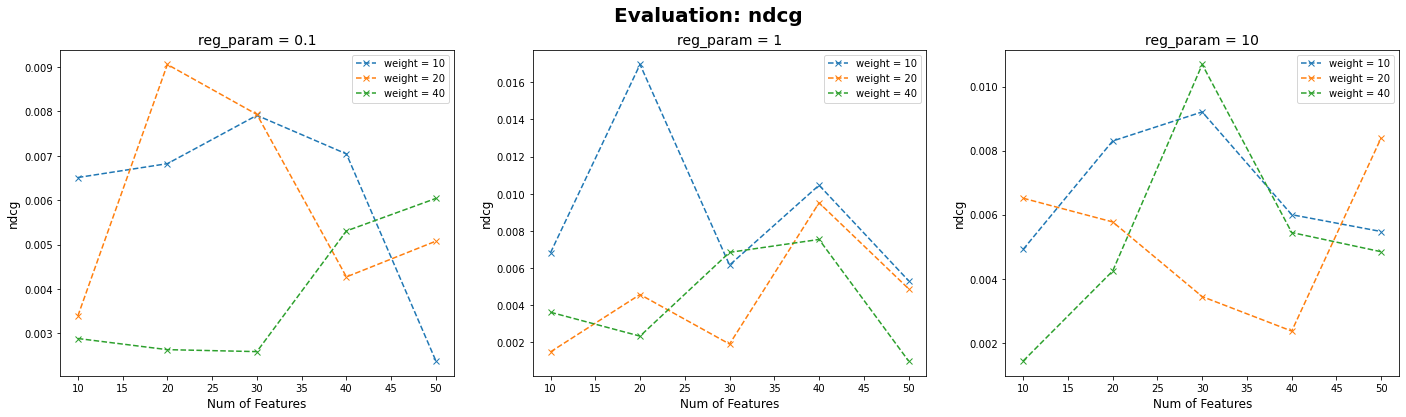

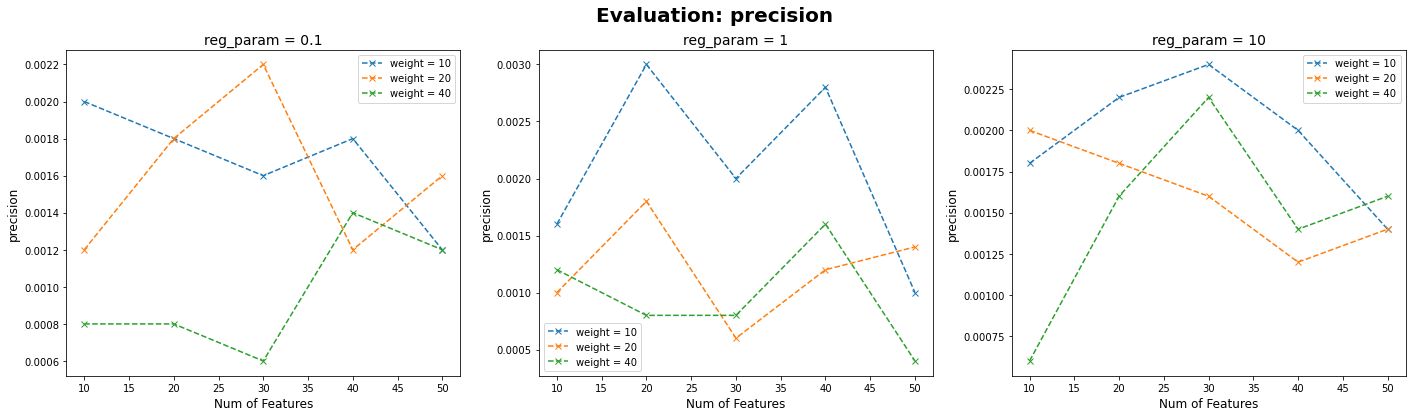

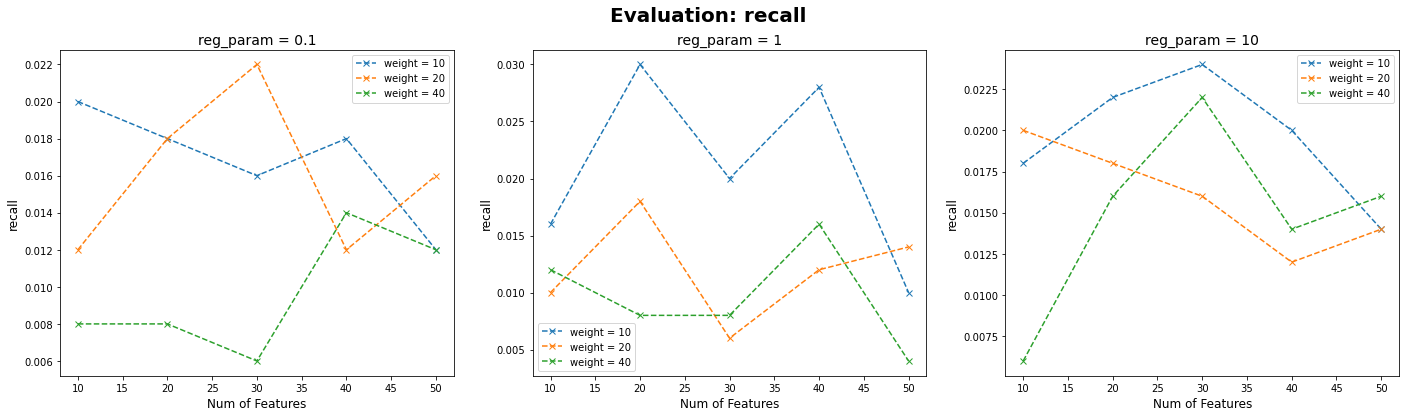

In [15]:
for method in ['ndcg', 'precision', 'recall']:
    i = 0
    fig, axs = plt.subplots(1, 3, figsize=[24,6])
    fig.suptitle(f'Evaluation: {method}', fontsize = 20, fontweight = 'bold')
    
    for reg in reg_set:        
        for weight in weight_set:
            result = metrics[(metrics['reg']==reg) & (metrics['weight']==weight)]
            score = result[method]

            axs[i].plot(feature_set, score, '--x', label='weight = %d'%weight)
            axs[i].set_title(f'reg_param = {reg}', fontsize = 14)

            axs[i].set_xlabel('Num of Features', fontsize = 12)
            axs[i].set_ylabel(method, fontsize = 12)
            axs[i].legend()

        i += 1

plt.show()

## Further tune on features

In [89]:
# best configuration
feature_set = [20, 50, 100]
r = 1
w = 10
iterations = 20
use_ratings = True

data = (df_train, df_test)

In [90]:
eval = MultiEval('my-test', recommend=500, save_models=False)  #set save_models=True when running on the full dataset
eval.add_datasets(data, name='Song')   

ALS = [als.ImplicitMF(features=f, iterations=iterations, reg=r, weight=w, use_ratings=use_ratings, method='cg', progress=tqdm) 
                        for f in feature_set]

eval.add_algorithms(ALS, attrs=['features', 'reg', 'weight'], name='ImplicitMF')

eval.run(progress = tqdm)

initializing deprecated MultiEval


  0%|          | 0/3 [00:00<?, ?it/s]

ImplicitMF:   0%|          | 0/20 [00:00<?, ?it/s]

ImplicitMF:   0%|          | 0/20 [00:00<?, ?it/s]

ImplicitMF:   0%|          | 0/20 [00:00<?, ?it/s]

In [106]:
runs_test = pd.read_csv('my-test/runs.csv')
runs_test.set_index('RunId', inplace=True)
runs_test['TrainTime']+runs_test['RecTime']

RunId
1     68.142419
2     91.270425
3    125.987777
dtype: float64

In [8]:
recs_test = pd.read_parquet('my-test/recommendations.parquet')

In [11]:
# calculate map
rla_map = topn.RecListAnalysis()
rla_map.add_metric(precision, k=1)


raw_metrics = rla_map.compute(recs_test, df_test,  include_missing=False)
raw_metrics.head()

nrecs  precision
RunId user                                                      
1     002b63a7e2247de6d62bc62f253474edc7dd044c    500        1.0
      0037cbbc2cd55e2ba6d6839b15175522339aadec    500        0.0
      00790e947706db2dbeace2919487b6f3b9db08a1    500        1.0
      00a55d1ba6f63109c208dbd80570520d5d80f563    500        0.0
      00b9144fc8cd453b81c362b30dbf8b8266eec220    500        1.0

In [108]:
rla = topn.RecListAnalysis()
rla.add_metric(topn.ndcg)
rla.add_metric(topn.recall)
rla.add_metric(topn.precision)

raw_metrics = rla.compute(recs_test, df_test,  include_missing=False)
raw_metrics = raw_metrics.join(runs_test[['features', 'TrainTime', 'RecTime']], on='RunId')
raw_metrics.head()

nrecs      ndcg    recall  \
RunId user                                                                  
1     002b63a7e2247de6d62bc62f253474edc7dd044c    500  0.173157  0.308411   
      0037cbbc2cd55e2ba6d6839b15175522339aadec    500  0.145954  0.226027   
      00790e947706db2dbeace2919487b6f3b9db08a1    500  0.163194  0.161290   
      00a55d1ba6f63109c208dbd80570520d5d80f563    500  0.048988  0.104895   
      00b9144fc8cd453b81c362b30dbf8b8266eec220    500  0.397424  0.408163   

                                                precision  features  \
RunId user                                                            
1     002b63a7e2247de6d62bc62f253474edc7dd044c      0.066        20   
      0037cbbc2cd55e2ba6d6839b15175522339aadec      0.066        20   
      00790e947706db2dbeace2919487b6f3b9db08a1      0.040        20   
      00a55d1ba6f63109c208dbd80570520d5d80f563      0.030        20   
      00b9144fc8cd453b81c362b30dbf8b8266eec220      0.160        20   

                                                TrainTime    RecTime  
RunId user                                                            
1     002b63a7e2247de6d62bc62f253474edc7dd044c  18.832965  49.309455  
      0037cbbc2cd55e2ba6d6839b15175522339aadec  18.832965  49.309455  
      00790e947706db2dbeace2919487b6f3b9db08a1  18.832965  49.309455  
      00a55d1ba6f63109c208dbd80570520d5d80f563  18.832965  49.309455  
      00b9144fc8cd453b81c362b30dbf8b8266eec220  18.832965  49.309455

In [109]:
metrics= raw_metrics.fillna(0).groupby(['features']).mean().reset_index()
metrics

,features,nrecs,ndcg,recall,precision,TrainTime,RecTime
0,20,500,0.149776,0.205003,0.057310,18.832965,49.309455
1,50,500,0.167893,0.235855,0.065844,26.473194,64.797230
2,100,500,0.178943,0.252079,0.070288,41.519581,84.468196


In [110]:
# total time = train time + recommendation time
Runtime = metrics['TrainTime'] + metrics['RecTime']

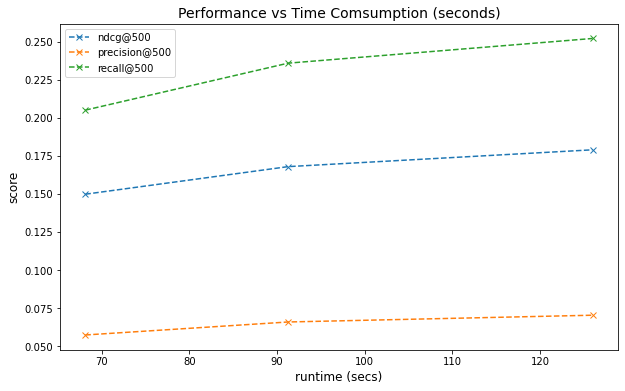

In [111]:
fig, ax = plt.subplots(figsize=[10,6])

ax.set_title('Performance vs Time Comsumption (seconds)', fontsize = 14)

ax.set_xlabel('runtime (secs)', fontsize = 12)
ax.set_ylabel('score', fontsize = 12)

for method in ['ndcg', 'precision', 'recall']:
    score = metrics[method]

    ax.plot(Runtime, score, '--x', label=f'{method}@500')
    ax.legend()

plt.savefig('time.png')
plt.show()